## Building a Hangul classifier
### By Dokyun Kim

This project focuses on developing a machine learning model capable of classifying handwritten Hangul characters from the Korean alphabet. As Korean media and culture continue to gain global popularity, an increasing number of people are learning Korean as a second language. This model can be used as an educational tool to enhance the language learning experience by helping students recognize and practice writing various Hangul characters. It could aid learners in quickly identifying character shapes, reinforcing their familiarity with characters, and improving handwriting skills. This model aims support learners in developing a stronger foundation in the Korean language.

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchsummary import summary
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Currently using {device}")

Currently using cuda


## Handwritten Hangul Dataset

To train the model, we are utilizing the *Handwritten Hangul Characters* dataset from Kaggle, which contains 2,400 images of individual Hangul characters, each sized at 28x28 pixels. Since our model is designed to work exclusively with grayscale images, we first pre-process the dataset by converting all images to grayscale. This step ensures compatibility with the model’s input requirements.

To explore the effects of data augmentation, we prepared two versions of the dataset: one containing only unaugmented images and the other combining both unaugmented and augmented images. For the augmented portion, we applied a random rotation of -20 to 20 degrees to each image, potentially enhancing the model's robustness by enabling it to generalize better to various handwriting styles and orientations. By comparing the model’s performance on these two datasets, we aim to assess the impact of augmentation on its accuracy and effectiveness in classifying handwritten Hangul characters.

In [59]:
transform_unaug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1]
])

transform_aug = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=(-20,20), fill=255), # Apply random rotation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing to [-1, 1]
])

dataset_unaug = datasets.ImageFolder(root='data/', transform=transform_unaug)
dataset_aug = datasets.ImageFolder(root='data/', transform=transform_aug)

# Combine unaugmented & augmented dataset into one
dataset_all = ConcatDataset([dataset_unaug, dataset_aug])

# Split dataset into 70% train, 30% test
train_size, test_size = 0.7, 0.3
batch_size = 40


train_set, test_set = random_split(dataset_all, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# train_unaug, test_unaug = random_split(dataset_unaug, [train_size, test_size])
# train_aug, test_aug = random_split(dataset_all, [train_size, test_size])

# train_loader_unaug = DataLoader(train_unaug, batch_size=batch_size, shuffle=True)
# test_loader_unaug = DataLoader(test_unaug, batch_size=batch_size, shuffle=False)

# train_loader_aug = DataLoader(train_aug, batch_size=batch_size, shuffle=True)
# test_loader_aug = DataLoader(test_aug, batch_size=batch_size, shuffle=False)

print(f"{len(dataset_all)} total images")
for images, labels in train_loader:
    print('Image Batch Dimension: ', images.shape)
    print('Image Labels Dimension: ', labels.shape)
    break



4800 total images
Image Batch Dimension:  torch.Size([40, 1, 28, 28])
Image Labels Dimension:  torch.Size([40])


### Visualizing the dataset

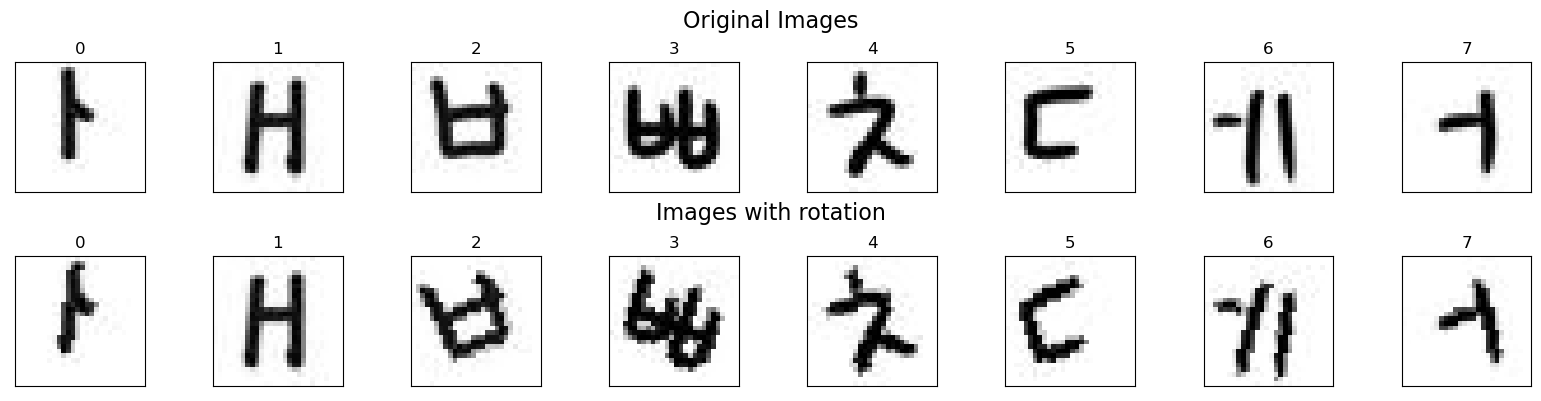

In [60]:
# Create a 2x8 grid of subplots
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

# Plot original images in the first row
for i in range(8):
    img, label = dataset_unaug[i*80]
    img = img.squeeze().numpy()
    axs[0, i].imshow(img, cmap='gray')
    axs[0, i].set_title(label)
    axs[0, i].axes.xaxis.set_visible(False)
    axs[0, i].axes.yaxis.set_visible(False)

# Plot augmented images in the second row
for i in range(8):
    img, label = dataset_aug[i*80]
    img = img.squeeze().numpy()
    axs[1, i].imshow(img, cmap='gray')
    axs[1, i].set_title(label)
    axs[1, i].axes.xaxis.set_visible(False)
    axs[1, i].axes.yaxis.set_visible(False)

# Add titles for each row of subplots
fig.text(0.5, 0.98, "Original Images", ha='center', fontsize=16, va='top')
fig.text(0.5, 0.5, "Images with rotation", ha='center', fontsize=16, va='top')

plt.tight_layout()
plt.subplots_adjust(top=0.85, hspace=0.5)

## Implementing a MLP solution

In [61]:
# Define MLP object

class Hangul_MLP(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, input_size, num_classes):
        """
        Constructor for MLP object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(Hangul_MLP, self).__init__()
        # initialize the model weights

        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, (input_size + num_classes) // 4),
            nn.Sigmoid(),
            nn.Linear((input_size + num_classes) // 4, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        out = self.linear_stack(x)
        out = F.softmax(out, dim=1)
        return out

print(summary(Hangul_MLP(784, 30).to(device), (1,784)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 203]         159,355
           Sigmoid-2               [-1, 1, 203]               0
            Linear-3                [-1, 1, 30]           6,120
           Sigmoid-4                [-1, 1, 30]               0
Total params: 165,475
Trainable params: 165,475
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.63
Estimated Total Size (MB): 0.64
----------------------------------------------------------------
None


### MLP with batch training

In [62]:
def run_MLP_batch(trainloader, testloader, n_epochs, learning_rate):

    model = Hangul_MLP(input_size = 784, num_classes = 30).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = np.zeros((n_epochs,))
    test_losses = np.zeros((n_epochs,))
    accuracies = np.zeros((n_epochs,))

    start = time.time()
    for epoch in range(n_epochs):

        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():

            total_test_loss, total_train_loss, correct_preds = 0.0, 0.0, 0.0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

                test_outputs = model(images)
                test_loss = criterion(test_outputs, labels)
                total_test_loss += test_loss.item()
                
                _, preds = torch.max(test_outputs, 1)
                correct_preds += (preds == labels).sum().item()

            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(images.size(0), -1) # Reshape to [batch_size, 784] from [batch_size, 1, 28, 28]

                train_outputs = model(images)
                train_loss = criterion(train_outputs, labels)
                total_train_loss += train_loss.item()

            accuracies[epoch] = correct_preds / len(testloader.dataset) * 100 # type: ignore
            test_losses[epoch] = total_test_loss / len(testloader)
            train_losses[epoch] = total_train_loss / len(trainloader)


            print('Epoch: %03d/%03d | Accuracy: %.3f%%' %(epoch + 1, n_epochs, accuracies[epoch]))
        
    print("Total Train Time: %.2f min" % ((time.time() - start)/60))
    return train_losses, test_losses, accuracies, model

In [63]:
train_losses, test_losses, accuracies, model = run_MLP_batch(train_loader, test_loader, 300, 0.8)

torch.save(model.state_dict(), "mlp.pth")

Epoch: 001/300 | Accuracy: 8.889%
Epoch: 002/300 | Accuracy: 30.069%
Epoch: 003/300 | Accuracy: 42.917%
Epoch: 004/300 | Accuracy: 58.194%
Epoch: 005/300 | Accuracy: 64.097%
Epoch: 006/300 | Accuracy: 64.722%
Epoch: 007/300 | Accuracy: 66.250%
Epoch: 008/300 | Accuracy: 67.083%
Epoch: 009/300 | Accuracy: 67.292%
Epoch: 010/300 | Accuracy: 70.903%
Epoch: 011/300 | Accuracy: 70.000%
Epoch: 012/300 | Accuracy: 71.667%
Epoch: 013/300 | Accuracy: 71.458%
Epoch: 014/300 | Accuracy: 73.333%
Epoch: 015/300 | Accuracy: 73.194%
Epoch: 016/300 | Accuracy: 74.583%
Epoch: 017/300 | Accuracy: 73.194%
Epoch: 018/300 | Accuracy: 73.958%
Epoch: 019/300 | Accuracy: 74.375%
Epoch: 020/300 | Accuracy: 76.042%
Epoch: 021/300 | Accuracy: 76.458%
Epoch: 022/300 | Accuracy: 77.014%
Epoch: 023/300 | Accuracy: 76.667%
Epoch: 024/300 | Accuracy: 77.014%
Epoch: 025/300 | Accuracy: 78.333%
Epoch: 026/300 | Accuracy: 79.028%
Epoch: 027/300 | Accuracy: 78.750%
Epoch: 028/300 | Accuracy: 79.167%
Epoch: 029/300 | Accu

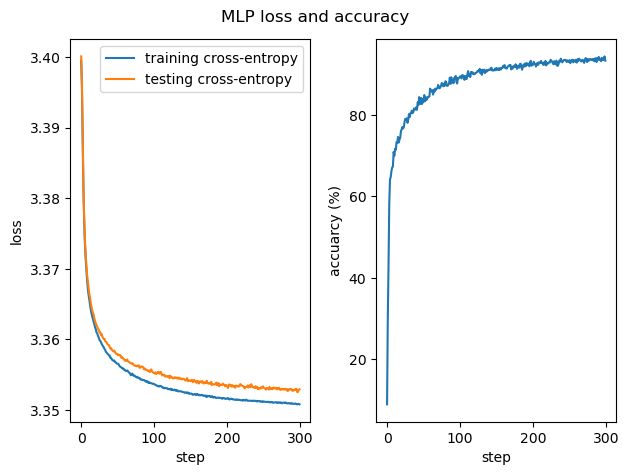

In [64]:
n_epochs = 300

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy (%)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("MLP loss and accuracy")
plt.show()

Analysis here

## Convolutional Neural Network (CNN)

While an MLP can perform image classification, it typically requires the image data to be flattened, which results in the loss of spatial information. Consequently, MLPs generally perform worse on image data compared to CNNs, as they cannot effectively capture spatial features.

CNNs, however, excel at image classification because they preserve the spatial structure of images through convolutional layers. These layers also reduce the number of parameters by sharing weights, enhancing the model's ability to learn intricate patterns. As a result, CNNs tend to achieve higher accuracy and efficiency in image classification tasks, especially when dealing with large-scale datasets and complex visual patterns.

To explore these differences further, we will recreate the LeNet-5 architecture, a CNN structure proposed by LeCun et al. We will assess whether LeNet-5 can outperform the MLP shown above.  

The LeNet-5 Architecture is shown below:  
</br>
<img src="LeNet.png" width="400">  
</br>
By Cmglee - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=104937230

In [65]:
# Define LeNet object

class LeNet(nn.Module):
    """
    A model that implements a logistic regression classifier. 
    """
    def __init__(self, num_classes):
        """
        Constructor for LeNet object

        Args:
            input_size (int): size of input tensor
            num_classes (int): number of classes the model can predict
        """
        super(LeNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),

            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),

            nn.Linear(in_features= 400, out_features=120),
            nn.ReLU(),

            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),

            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the model

        Args:
            x (tensor): Input to the model
        
        Returns:
            out (tensor): Output of the model

        """
        # First Conv Layer
        x = self.layers[0](x)
        x = self.layers[1](x)
        x = self.layers[2](x)  

        # Second Conv Layer
        x = self.layers[3](x)
        x = self.layers[4](x)
        x = self.layers[5](x)  
        
        # Flatten and Fully Connected Layers
        x = self.layers[6](x)
        x = self.layers[7](x)
        x = self.layers[8](x)
        x = self.layers[9](x)
        x = self.layers[10](x)
        x = self.layers[11](x)
        return x

print(summary(LeNet(30).to(device), (1,28,28)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                   [-1, 30]           2,550
Total params: 63,406
Trainable params: 63,406
Non-trainable params: 0
---------------------------------

In [66]:
def train_LeNet(trainloader, testloader, n_epochs, learning_rate):
    model = LeNet(num_classes = 30).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = np.zeros((n_epochs,))
    test_losses = np.zeros((n_epochs,))
    accuracies = np.zeros((n_epochs,))

    start = time.time()
    for epoch in range(n_epochs):

        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


        model.eval()
        with torch.no_grad():

            total_test_loss, total_train_loss, correct_preds = 0.0, 0.0, 0.0

            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                test_outputs = model(images)
                test_loss = criterion(test_outputs, labels)
                total_test_loss += test_loss.item()
                
                _, preds = torch.max(test_outputs, 1)
                correct_preds += (preds == labels).sum().item()
            
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                train_outputs = model(images)
                train_loss = criterion(train_outputs, labels)
                total_train_loss += train_loss.item()
            
            accuracies[epoch] = correct_preds / len(testloader.dataset) * 100
            test_losses[epoch] = total_test_loss / len(testloader)
            train_losses[epoch] = total_train_loss / len(trainloader)
            
            print('Epoch: %03d/%03d | Accuracy: %.3f%%' %(epoch + 1, n_epochs, accuracies[epoch]))
        
    print("Total Train Time: %.2f min" % ((time.time() - start)/60))
    return train_losses, test_losses, accuracies, model

In [69]:
train_losses, test_losses, accuracies, model = train_LeNet(train_loader, test_loader, 30, 0.001)

torch.save(model.state_dict(), "lenet.pth")

Epoch: 001/030 | Accuracy: 49.236%
Epoch: 002/030 | Accuracy: 72.431%
Epoch: 003/030 | Accuracy: 83.194%
Epoch: 004/030 | Accuracy: 87.986%
Epoch: 005/030 | Accuracy: 88.750%
Epoch: 006/030 | Accuracy: 94.653%
Epoch: 007/030 | Accuracy: 95.000%
Epoch: 008/030 | Accuracy: 93.611%
Epoch: 009/030 | Accuracy: 91.736%
Epoch: 010/030 | Accuracy: 96.181%
Epoch: 011/030 | Accuracy: 95.903%
Epoch: 012/030 | Accuracy: 96.944%
Epoch: 013/030 | Accuracy: 96.528%
Epoch: 014/030 | Accuracy: 94.514%
Epoch: 015/030 | Accuracy: 96.875%
Epoch: 016/030 | Accuracy: 97.778%
Epoch: 017/030 | Accuracy: 96.667%
Epoch: 018/030 | Accuracy: 97.917%
Epoch: 019/030 | Accuracy: 98.264%
Epoch: 020/030 | Accuracy: 97.778%
Epoch: 021/030 | Accuracy: 96.736%
Epoch: 022/030 | Accuracy: 97.014%
Epoch: 023/030 | Accuracy: 97.708%
Epoch: 024/030 | Accuracy: 96.042%
Epoch: 025/030 | Accuracy: 96.181%
Epoch: 026/030 | Accuracy: 96.806%
Epoch: 027/030 | Accuracy: 98.125%
Epoch: 028/030 | Accuracy: 98.125%
Epoch: 029/030 | Acc

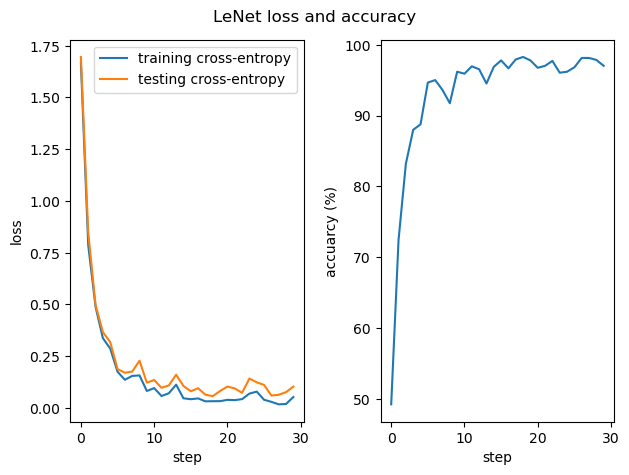

In [70]:
n_epochs = 30

plt.figure()
plt.subplot(1,2,1)
plt.plot(range(n_epochs), train_losses, label='training cross-entropy')
plt.plot(range(n_epochs), test_losses, label='testing cross-entropy')
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(n_epochs), accuracies)
plt.xlabel('step')
plt.ylabel('accuarcy (%)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("LeNet loss and accuracy")
plt.show()

## Model Evaluation

In [71]:
mlp = Hangul_MLP(input_size=784, num_classes=30)
mlp.load_state_dict(torch.load('mlp.pth'))

lenet = LeNet(num_classes=30)
lenet.load_state_dict(torch.load('lenet.pth'))

<All keys matched successfully>

A common method for evaluating a classification model is by using a confusion matrix. This matrix enables the calculation of metrics such as True Positives, True Negatives, False Positives, and False Negatives. These metrics can then be used to determine measures like Precision and Recall.

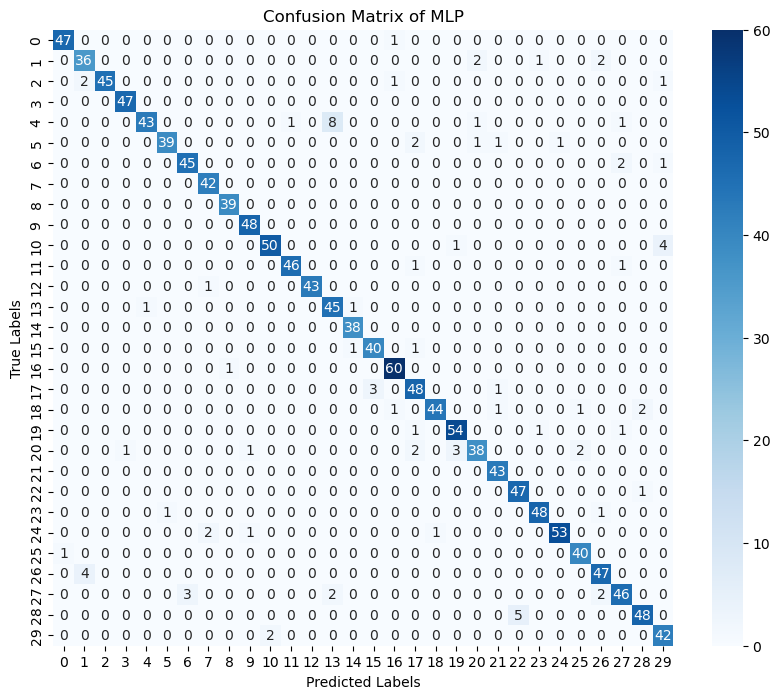

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_true_labels = []

with torch.no_grad():
    for imgs, labels_true in test_loader:
        imgs = imgs.view(imgs.size(0), -1)
        outputs = mlp(imgs)
        # print(outputs)
        _, labels_pred = torch.max(outputs, 1)

        all_preds.extend(labels_pred.numpy())
        all_true_labels.extend(labels_true.numpy())

conf_matrix_mlp = confusion_matrix(all_true_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of MLP')
plt.show()